# knn approach to finding traces with flipped polarity in seismic data

We use ML to classify the polarity $(\pm 1)$ of seismic traces. Each trace corresponds to a hydrophone which listens for sound wave reflecting from the geology in the subsurface of the Earth. The sound waves have "shots" as their sources. These shots are denotations set off above the ground.

Sometimes the channel arrays have geophones which are recording data with a phase inversion of -1. That is, they record -f(t) when they should be recording f(t). To process seismic data into a tomographic image, these flipped polarity traces need to be identified.

This open source seismic data comes with channels that have this error. We use a nearest-neighbors algorithm to catalog them.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [3]:
raw_data = pd.read_csv('seismic_traces.txt',header=None,skiprows=[0])

The data is being read as series:

In [4]:
raw_data.shape

(5391360, 1)

But each datapoint is made up of 51 attributes and a target label $(\pm 1)$, so we need to reorganize:

In [5]:
raw_data.head(5)

,0
0,channel=1 shot=2372 label=-1
1,0 1.35109469e-01
2,1 -1.49369106e-01
3,2 1.57715330e+01
4,3 1.42361059e+01


In [6]:
def series_to_dataframe(series,length,sample):
    #function to convert series to dataframe such that entries
    #within [sample_i,sample_(i+52), i % sample = 0, are mapped to a column
    #length = total entries from series to be mapped to the dataframe
    
    df = pd.DataFrame(index=range(0,sample+1))

    for x in range(0,int(length),sample): #for production len(df), or len(df)/2
        df[x] = pd.Series(series.iloc[x:x+53,0].reset_index()[0])
       
    return df

In [7]:
traces_df = series_to_dataframe(raw_data, len(raw_data)/2, 52)

traces_df.head()

,0,52,104,156,208,260,312,364,416,468,...,2695160,2695212,2695264,2695316,2695368,2695420,2695472,2695524,2695576,2695628
0,channel=1 shot=2372 label=-1,channel=9 shot=2372 label=1,channel=17 shot=2372 label=1,channel=25 shot=2372 label=1,channel=33 shot=2372 label=1,channel=41 shot=2372 label=-1,channel=49 shot=2372 label=1,channel=57 shot=2372 label=1,channel=65 shot=2372 label=1,channel=73 shot=2372 label=1,...,channel=2225 shot=6668 label=1,channel=2233 shot=6668 label=1,channel=2241 shot=6668 label=-1,channel=2249 shot=6668 label=1,channel=2257 shot=6668 label=1,channel=2265 shot=6668 label=1,channel=2273 shot=6668 label=1,channel=2281 shot=6668 label=-1,channel=2289 shot=6668 label=1,channel=2297 shot=6668 label=1
1,0 1.35109469e-01,0 1.45933300e-01,0 -6.92833722e-01,0 -5.48514366e-01,0 -5.12570068e-02,0 -8.86980057e-01,0 -1.76063627e-01,0 2.22643271e-01,0 1.17118979e+00,0 5.71239889e-01,...,0 -5.05644798e+01,0 -5.35335121e+01,0 5.16573334e+01,0 -6.36245384e+01,0 -6.22858963e+01,0 -6.69708176e+01,0 -6.17421837e+01,0 4.24557686e+01,0 -3.49117241e+01,0 -3.27148094e+01
2,1 -1.49369106e-01,1 1.75313914e+00,1 1.99631679e+00,1 3.04945016e+00,1 2.88342237e+00,1 -1.33383894e+00,1 1.71477425e+00,1 1.66236949e+00,1 2.14069176e+00,1 1.45541644e+00,...,1 -2.43941898e+01,1 -2.50681992e+01,1 1.98644161e+01,1 -2.24622288e+01,1 -1.41626024e+01,1 -1.40747652e+01,1 -7.30249357e+00,1 1.30712271e+01,1 -8.87607956e+00,1 -1.96998653e+01
3,2 1.57715330e+01,2 -1.49585085e+01,2 -2.35901699e+01,2 -2.49880772e+01,2 -3.32448540e+01,2 2.98935757e+01,2 -3.22538071e+01,2 -2.51346836e+01,2 -1.51347399e+01,2 -5.07944202e+00,...,2 -2.13396549e+01,2 -1.86809387e+01,2 2.29194832e+01,2 -1.65655098e+01,2 -2.28135605e+01,2 -2.79594479e+01,2 -2.25943642e+01,2 3.03915577e+01,2 -2.37743130e+01,2 -2.82103367e+01
4,3 1.42361059e+01,3 -1.81383457e+01,3 -1.35441465e+01,3 -7.66792870e+00,3 -1.11441040e+01,3 1.45502367e+01,3 -1.61157742e+01,3 -1.30265388e+01,3 -2.11821022e+01,3 -3.24019890e+01,...,3 -1.31772375e+01,3 -7.91394949e+00,3 2.81915817e+01,3 -2.24558468e+01,3 -3.33276749e+01,3 -3.37345467e+01,3 -2.52948914e+01,3 2.34377728e+01,3 -1.42750978e+01,3 -7.85312891e+00


In [8]:
def select_amplitude(x):
    #function to select the amplitude value from each cell:
    # '2 -2.35901699e+01'  ---> '-2.35901699e+01'
    
    ls = x.split()
    return ls[len(ls)-1]

def pickSign(str):      
    # function to pick send 'gut=-1' ---> -1, 'gut=1' ---> 1
    
    if str[-2:-1]=='-':
        return -1
    else:
        return 1

In [22]:
#Select amplitude value from each cell. 
#Transpose so that the samples of the traces become attributes
data_df = traces_df.applymap(select_amplitude).transpose()

#Create integer target label
data_df['Polarity']= data_df[0].apply(pickSign)
data_df = data_df.drop(labels=[0,52],axis=1)
data_df = data_df.astype('float')

**Now we have the data in the shape that we want. Every row corresponds to a data point, with the entries being the samples of the recorded sound waves. The last column contains the polarity label.**

In [23]:
data_df.head()

,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,Polarity
0,0.135109,-0.149369,15.771533,14.236106,-35.925736,26.909462,-15.012988,1.725460,7.095699,1.463356,...,3.210323,-6.106526,-6.634347,7.872420,6.820869,-4.395456,7.422894,17.544140,3.223560,-1.0
52,0.145933,1.753139,-14.958509,-18.138346,24.836264,-1.771277,6.107979,0.650433,12.429290,-20.766388,...,-6.895596,-2.262812,0.867932,6.583002,-2.523254,1.952146,-1.058738,0.687788,5.562509,1.0
104,-0.692834,1.996317,-23.590170,-13.544147,16.388670,-2.811234,0.292026,19.967159,18.820869,-14.062235,...,5.066412,-4.839576,-7.733660,3.416450,-2.488747,-0.623854,-5.784183,-1.940175,3.148644,1.0
156,-0.548514,3.049450,-24.988077,-7.667929,17.888163,-11.045793,9.761217,11.444410,4.486601,-8.396764,...,8.914586,4.633519,-0.462167,-4.352639,-6.807166,4.047869,5.908732,-9.539698,-5.924528,1.0
208,-0.051257,2.883422,-33.244854,-11.144104,16.647282,-15.133264,21.228491,4.141500,11.930402,-1.909803,...,5.179042,-3.362991,6.316719,8.003730,-8.228494,-1.989292,13.240460,7.562987,-2.874917,1.0


In [24]:
data_df.shape

(51840, 52)

In [12]:
# To write out the above dataframe to have it stored after the flow of modifications, use:
# df4.to_csv('parallel_traces.csv',index=False)

## Training/testing split. Resampling the data

We note that the data is umbalanced. There are about ~4x as many taces with positive polarity than negative. So we we address this issue by resampling the number of negative-polarity traces by upsampling this category.

In [25]:
print('Number of seismic traces with positive polarity =', len(data_df[data_df.Polarity == 1]))
print('Number of seismic traces with negative polarity =', len(data_df[data_df.Polarity == -1]))

Number of seismic traces with positive polarity = 41400
Number of seismic traces with negative polarity = 10440


In [76]:
X_train.head(3)

,1,2,3,4,5,6,7,8,9,10,...,42,43,44,45,46,47,48,49,50,51
2137148,-27.532476,-17.591280,10.046768,-21.997803,-18.320148,23.392122,-22.206720,52.330212,11.693470,-9.435547,...,7.177879,-0.023017,-0.044595,-0.213631,0.270822,-2.558987,2.936208,1.397922,-3.780095,-0.486677
362492,-0.414423,-0.715706,-0.678090,1.482096,5.831844,27.480686,13.823550,35.453995,-2.047973,12.124044,...,-12.862269,4.966902,-0.357170,8.553045,-2.303917,4.615224,0.317074,0.578510,4.448454,-4.389345
1676116,99.320251,-57.688053,-117.979378,102.668655,-33.522755,-65.195419,-18.945452,112.786255,-55.418331,-46.398830,...,13.107399,1.270122,-0.812378,2.281932,0.660264,13.656757,-7.672723,34.929375,-10.637832,7.645483


In [99]:
#train/test split
X = data_df.drop(labels='Polarity',axis=1)
y = data_df['Polarity']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=12)


# Standardize the attributes
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_s = pd.DataFrame(scaler.transform(X_train),index=X_train.index)
X_test_s = pd.DataFrame(scaler.transform(X_test),index=X_test.index)

In [101]:
from sklearn.utils import resample

#re-merge training attributes and labels to resample
all_training_s = X_train_s.copy()
all_training_s['Polarity'] = y_train

# We upsample the minority class by creating random copies of the 
# samples in this class.

new_negative_batch_s = resample(all_training_s[all_training_s.Polarity == -1], n_samples = 23196, random_state=0)
balanced_training_s = pd.concat([all_training_s,new_negative_batch_s])


#Peel off the labels again:
X_train_balanced_s = balanced_training_s.drop(labels='Polarity',axis=1)
y_train_balanced_s = balanced_training_s['Polarity']

print('\n~~~~~~~~~~ After upsampling training data:\n ')
print('Number of training seismic traces with positive polarity =', len(balanced_training_s[balanced_training_s.Polarity == 1]))
print('Number of training seismic traces with negative polarity =', len(balanced_training_s[balanced_training_s.Polarity == -1]))


~~~~~~~~~~ After upsampling training data:
 
Number of training seismic traces with positive polarity = 31038
Number of training seismic traces with negative polarity = 31038


In [83]:
from sklearn.utils import resample

#re-merge training attributes and labels to resample
all_training = X_train.copy()
all_training['Polarity'] = y_train

print('\n~~~~~~~~~~ Before upsampling training data:\n ')
print('Number of seismic traces with positive polarity =', len(all_training[all_training.Polarity == 1]))
print('Number of seismic traces with negative polarity =', len(all_training[all_training.Polarity == -1]))

# We upsample the minority class by creating random copies of the 
# samples in this class.

new_negative_batch = resample(all_training[all_training.Polarity == -1], n_samples = 23196, random_state=0)
balanced_training = pd.concat([all_training,new_negative_batch])


print('\n~~~~~~~~~~ After upsampling training data:\n ')
print('Number of training seismic traces with positive polarity =', len(balanced_training[balanced_training.Polarity == 1]))
print('Number of training seismic traces with negative polarity =', len(balanced_training[balanced_training.Polarity == -1]))

#Peel off the labels again:
X_train_balanced = balanced_training.drop(labels='Polarity',axis=1)
y_train_balanced = balanced_training['Polarity']



~~~~~~~~~~ Before upsampling training data:
 
Number of seismic traces with positive polarity = 31038
Number of seismic traces with negative polarity = 7842

~~~~~~~~~~ After upsampling training data:
 
Number of training seismic traces with positive polarity = 31038
Number of training seismic traces with negative polarity = 31038


## Building the nearest-neighbors model
We proceed to build the model with balanced training data.

We test to find the optimal k, the number of neighbors, via cross validation using cross_val_score. Since this is a classification problem, we test for accuracy.

In [38]:
cv_scores = []
for n in range(1,14,2):
    knn = KNeighborsClassifier(n_neighbors=n,weights='uniform')
    scores = cross_val_score(knn, X_train_balanced, y_train_balanced, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())

In [113]:
cv_scores_s = []
for n in range(1,14,2):
    knn = KNeighborsClassifier(n_neighbors=n,weights='uniform')
    scores = cross_val_score(knn, X_train_balanced_s, y_train_balanced, cv=3, scoring='accuracy')
    cv_scores_s.append(scores.mean())


 Optimal k = 1


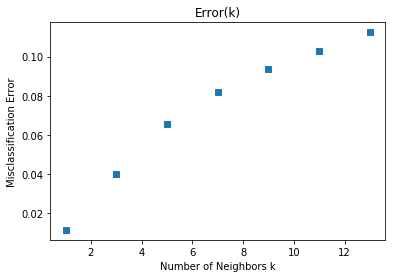

In [39]:
# Let's plot the misclassification error, call it msc

msc = [1 - x for x in cv_scores]
n_vals = (list(range(1,14,2)))

# Print the optimal k value
optimalMSC = n_vals[msc.index(min(msc))]
print('\n Optimal k =', optimalMSC)

plt.plot(n_vals, msc,'s')
plt.title('Error(k)')
plt.xlabel("Number of Neighbors k")
plt.ylabel("Misclassification Error")
plt.show()




 Optimal k = 1


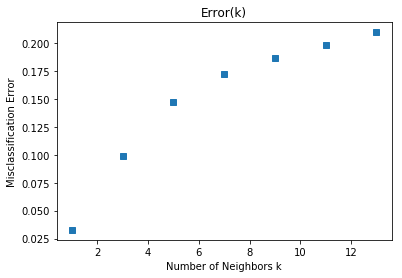

In [115]:
# Let's plot the misclassification error, call it msc

msc_s = [1 - x for x in cv_scores_s]
n_vals = (list(range(1,14,2)))

# Print the optimal k value
optimalMSC_s = n_vals[msc_s.index(min(msc_s))]
print('\n Optimal k =', optimalMSC_s)

plt.plot(n_vals, msc_s,'s')
plt.title('Error(k)')
plt.xlabel("Number of Neighbors k")
plt.ylabel("Misclassification Error")
plt.show()



In [103]:
knn1 = KNeighborsClassifier(n_neighbors=1, weights='uniform').fit(X_train_balanced,y_train_balanced)
print('Score for k = 1 knn-model', knn1.score(X_test,y_test))

Score for k = 1 knn-model 0.9496141975308642


In [104]:
knn1_s = KNeighborsClassifier(n_neighbors=1, weights='uniform').fit(X_train_balanced_s,y_train_balanced)
print('Score for k = 1 knn-model', knn1.score(X_test_s,y_test))

Score for k = 1 knn-model 0.7563271604938272


In [107]:
y_pred=knn1.predict(X_test)
y_pred_s = knn1_s.predict(X_test_s)

In [111]:
all_results = pd.DataFrame({'actual':y_test,'knn1':y_pred,'knn1_s':y_pred_s})
all_results.head(20)

,actual,knn1,knn1_s
2243280,1.0,1.0,1.0
2352584,1.0,1.0,1.0
443092,1.0,1.0,-1.0
1761708,1.0,1.0,1.0
715780,1.0,1.0,1.0
509080,1.0,1.0,1.0
864604,1.0,1.0,1.0
489372,-1.0,-1.0,1.0
1493180,1.0,1.0,1.0
2217280,1.0,1.0,1.0


## 3 features

In [73]:
X_train_balanced_3d = X_train_balanced[[1,2,3]]
X_test_3d = X_test[[1,2,3]]

In [74]:
knn_3d = KNeighborsClassifier(n_neighbors=1, weights='uniform').fit(X_train_balanced_3d, y_train_balanced)
print('Score for k = 1 knn-model with 3 attributes =',knn_3d.score(X_test_3d,y_test))

Score for k = 1 knn-model with 3 attributes = 0.8083333333333333


In [75]:
dummy_constant = DummyClassifier(strategy='constant',constant=1).fit(X_train_balanced_3d,y_train_balanced)
dummy_constant.score(X_test_3d,y_test)

0.799537037037037

### Let's plot the 2d model

We will use the model based on the first two attributes.

In [62]:
x1_min, x1_max = X_train_balanced[1].min() - 1, X_train_balanced[1].max() + 1
x2_min, x2_max = X_train_balanced[2].min() - 1, X_train_balanced[2].max() + 1

In [63]:
h = 1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),
                         np.arange(x2_min, x2_max, h))

In [68]:
Z = knn1.predict(np.c_[xx.ravel(), yy.ravel()])

In [51]:
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

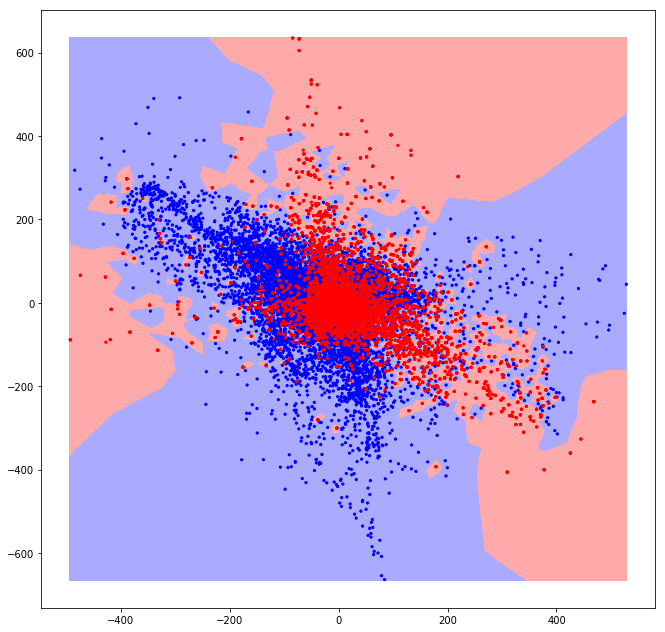

In [53]:
Z = Z.reshape(xx.shape)
plt.figure(figsize=(11,11))
plt.pcolormesh(xx, yy, Z,cmap=cmap_light)

# plotting the training data points
plt.scatter(X_train_balanced_2d[1].astype('float'),X_train_balanced_2d[2].astype('float'),c=y_train_balanced,s=5,cmap=cmap_bold)
plt.show()


### Can we improve our results if we normalize the input data?

We will see if that in the 2d-dimensional case l2-normalization of each trace is not helpful (actually harmful).

In [48]:
from sklearn.preprocessing import Normalizer

In [49]:
transformer = Normalizer(norm='l2').fit(X2d_train_2)
X2d_train_scaled = transformer.transform(X2d_train_2)
X2d_test_scaled = transformer.transform(X2d_test_2)

In [50]:
X2d_train_2.head()

,1,2
439660,-1.03471923e+00,-5.97857475e-01
1914016,2.51424591e+02,1.54621094e+02
420420,1.45749524e-01,-2.43782178e-01
309868,1.59413166e+01,3.41016121e+01
1598064,-1.05631836e+02,1.04834702e+02


In [51]:
X2d_train_scaled

array([[-0.86585793, -0.50028996],
       [ 0.85181212,  0.52384741],
       [ 0.51314951, -0.85829924],
       ...,
       [-0.84555938, -0.53388139],
       [ 0.16935147,  0.98555572],
       [-0.53483076, -0.8449592 ]])

In [52]:
nrnb_scaled = KNeighborsClassifier(n_neighbors=30,weights='uniform').fit(X2d_train_scaled,y2d_train_2)

In [54]:
print('After ls-normalizing each observation, we obtain an accuracy of', nrnb_scaled.score(X2d_test_scaled,y2d_test_2))

After ls-normalizing each observation, we obtain an accuracy of 0.7949845679012346


Normalizing isn't helpful for this dataset.